# Learning `scan` with `jax` and `numpyro`

Learning `scan` - it's in the LGT time series example and it looks really powerful.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

## `scan` components:

1. **Input Function `f(carry, x)`**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State `init`**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Array sequence `xs`**: An iterable or sequence that you want to iterate over

Then `scan` will do the following:
* **Sequencing**: The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
* **Aggregation**: The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

The Input function also returns two items:

1. The carried over value(s), aka the latest state
2. An array, where each element is something returned from the Input Function `f` as it passes each element in `xs`



In [15]:
from jax import random
import jax.numpy as jnp

## Trival Example 1 - Cumulative Sum

* [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)

We'll start with the cumsum example from [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html). We can implement a cumsum with a `for` loop like:

In [16]:
# xs
xs = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
cumsum = 0
for el in xs:
    cumsum += el
    result.append(cumsum)
jnp.array(result)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [17]:
jnp.cumsum(xs)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, instead of a for loop, we rewrite it using `lax.scan`:

In [18]:
from jax import lax

def cumsum(cumsum, el):
    """
    Parameters
    ----------
    res : tuple
        A tuple - the result from the previous loop, aka the 'carry'
    el
        The current array element, also `x`
    """
    cumsum += el
    return cumsum, cumsum # ('carryover', 'accumulated')

init_sum = 0
final, result = lax.scan(cumsum, init_sum, xs)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


we see that `lax.scan` returned two things: 
* The first item is the latest value of `res`
* The second item being returned is an array where each iteration appended the latest value of `res` to the end.

## Trivial Example 2: A little more of the carry function

The first two parameters in the input function can have arbitrary names but their order matters. The first item is the 'carried over value' and the second item is the current element in the `xs` input array.

Similarly the input function must have two outputs. The first output becomes the new 'carried over value' that will feed back into the input function, while the second output gets appended to an output `jax` array.

Let's have a concrete example in which we calculate compounded interest for a $100 investment with a 4% interest rate:

In [19]:
# Define a function to apply at each time step
def interest_growth(value, x):
    value = value * 1.04
    return value, value # ('carried over value', 'accumulated array')

# Define the initial state and input sequence
init_state = 100.0
T = jnp.array([1, 2, 3, 4, 5])
T = jnp.arange(1, 30)

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
final_state, results = lax.scan(f=interest_growth, init=init_state, xs=T)

print(final_state)
print(results)

311.8648
[104.       108.159996 112.48639  116.98584  121.66527  126.531876
 131.59314  136.85686  142.33113  148.02437  153.94534  160.10315
 166.50726  173.16754  180.09424  187.298    194.78992  202.58151
 210.68477  219.11215  227.87663  236.99168  246.47134  256.3302
 266.5834   277.24673  288.33658  299.87003  311.8648  ]


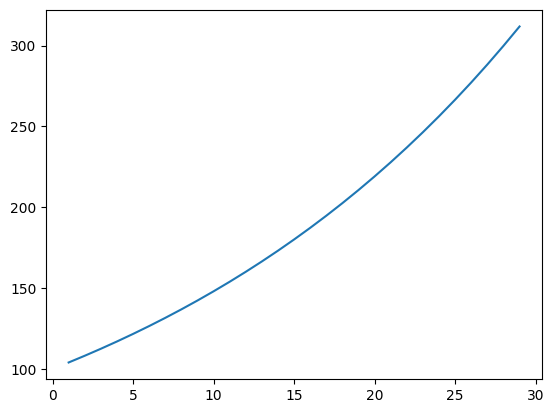

In [20]:
import matplotlib.pyplot as plt

plt.plot(T, results)

And we see the effect of the interest compounding over time.

## Trivial Example 3: `scan` in Numpyro to sample from a distribution

And what I'm really interested in is learning `scan` in the context of doing time series in `numpyro`. 

`numpyro` has it's own (experimental) implementation of `scan` which allows us to iteratively sample from `numpyro` primitives like `numpyro.distributions`. 

Here's a simple example of a random walk:

$$
y_{t+1} = y_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0,1)
$$

To do this within a `scan` we'll also need to introduce an *effect handler*: `numpyro.handlers.seed` and run the `scan` function within that context.

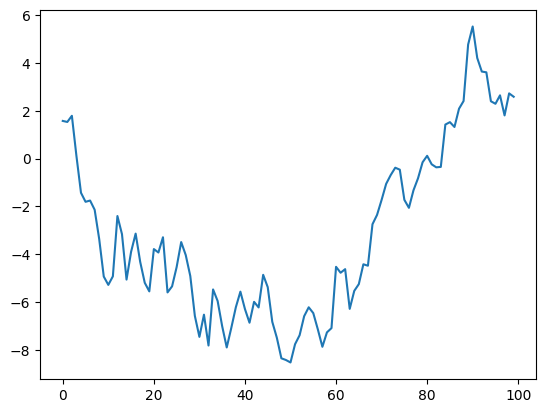

In [163]:
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
import matplotlib.pyplot as plt

def random_walk(value, x):    
    value = numpyro.sample('x', dist.Normal(value, 1.))
    # Which is the same as if we were very explicit:
    # value = value + numpyro.sample('x', dist.Normal(0, 1.))
    return value, value

init_0 = 0
n_steps = 100
T = jnp.arange(n_steps)

# Need the `seed` effect handler in a context manager because of
# the need for a PRNG key within `numpyro.sample`
with numpyro.handlers.seed(rng_seed=42):
    final_location, locations = scan(random_walk, init=init_0, xs=T)

plt.plot(T, locations);

Note the addition of `numpyro.handlers.seed`. This is required due to how `numpyro` requires an explicit PRNG key when you `sample` from a distribution, so this `seed` effect handler will automatically do the `split`s on the key within each loop of the `scan` function. 

Otherwise, if you set up an explicit key with `scan` this is what you'd get:

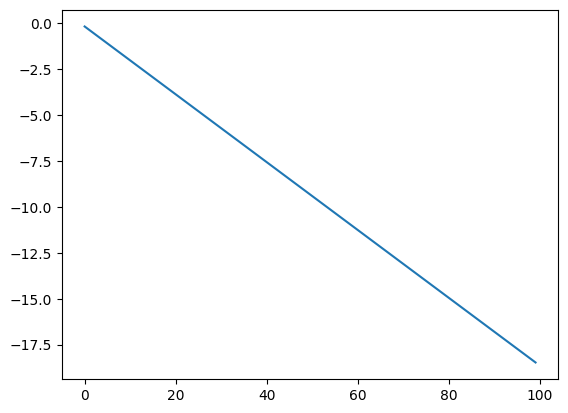

In [164]:
prng_key = random.PRNGKey(42)

def random_walk_nokey(value, x):
    # Being really explicit here
    value = value + numpyro.sample('x', dist.Normal(0, 1.), rng_key=prng_key)
    return value, value

init_0 = 0
n_steps = 100

state, final_result = scan(random_walk_nokey, init=init_0, xs=jnp.arange(n_steps))

plt.plot(jnp.arange(n_steps), final_result);

# Time Series Analysis

Understanding `scan` and effect handlers will help us understand the examples in the numpyro docs and to build our own Bayesian time series models with `numpyro` without relying on `for` loops.

## Gaussian Random Walk

For our first model, we can simply take our trivial example of a gaussian random walk and use `numpyro` to infer hidden parameters.



In [165]:
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import matplotlib.pyplot as plt
import arviz as az

Example: numpyro sample from a distribution

In [172]:
# gaussian random walk model

def random_walk_model(y):

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))

    def transition_fn(carry, t):
        level_t = carry
        new_level = numpyro.sample("level", dist.Normal(level_t, sigma_level)) # observed
        return new_level, None
    
    n_steps = y.shape[0]
    T = jnp.arange(1, n_steps) # because first value in the array is the init

    with numpyro.handlers.condition(data={"level": y[1:]}):
        state, final_result = scan(transition_fn, init=y[0], xs=T)

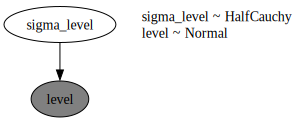

In [173]:
numpyro.render_model(random_walk_model, model_args=(locations,), render_distributions=True)

Note we added a `condition` handler so that we treat the `level` random variable as 'observed' and the only parameter we are concerned with is the `sigma_level` or $\sigma$ value in our gaussian random walk.

We then can use numpyro's MCMC inference engine to sample from the posterior and retrieve the distribution of `sigma_level`.

In [174]:
# Inference
def run_inference(model, y):
    mcmc = MCMC(sampler=NUTS(model), 
                num_samples=1000, 
                num_warmup=1000)
    mcmc.run(prng_key, y=y)
    return mcmc

mcmc = run_inference(random_walk_model, locations)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2123.13it/s, 1 steps of size 8.47e-01. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_level      0.99      0.07      0.98      0.87      1.11    371.48      1.00

Number of divergences: 0


We see yea verily that we can recover the unknown $\sigma$ from the random walk.

Note: Plotting this stuff doesn't do us any good because we the time series itself is treated as 'observed' - so prior predictive and posterior predictive doesn't work as you would expect. Instead, what you *can* do is try to do a 1-step ahead forecast if we need to plot something, but best to skip...

## AR(2) Example

* [Example: AR2 process (numpyro docs)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c, \alpha_1, \alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [175]:
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry # now, carry is a tuple which we unpack
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)

Note that we added another effect handler `condition` which, in this case, is conditioning $y_t$ on observed values $y$, excluding the first two values (because it's an AR(2) model).

Next we'll test this model on simulated data

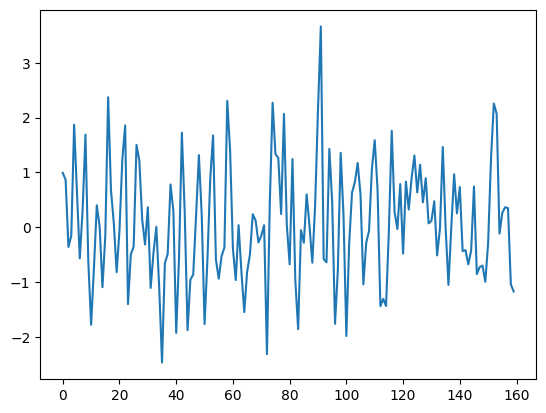

In [180]:
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

# constants
num_data = 160

def sim_ar2_process(num_data):
    t = jnp.arange(0, num_data)

    # Generate an AR(2) model with true alpha_1=0.5, alpha_2=-0.4 and a constant.
    # Statsmodels `ArmaProcess` requires that we flip the signs in the input:
    ar_coef = jnp.array([1, -0.5, 0.4])
    ma_coef = jnp.array([1])
    arproc = ArmaProcess(ar_coef, ma_coef)

    # Generate the data and convert to a jax array
    y = arproc.generate_sample(num_data)
    y = jnp.array(y)
    return y

y = sim_ar2_process(num_data)
# look at the data real quick:
plt.plot(y);

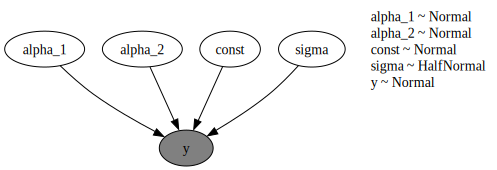

In [179]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [181]:
# Inference

rng_key = random.PRNGKey(123)
sampler = NUTS(ar2_scan)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1322.04it/s, 7 steps of size 7.24e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.38      0.08      0.38      0.25      0.50    872.35      1.00
   alpha_2     -0.37      0.08     -0.37     -0.50     -0.25    901.90      1.00
     const      0.08      0.08      0.08     -0.04      0.20    766.57      1.00
     sigma      0.97      0.06      0.97      0.87      1.06   1018.39      1.00

Number of divergences: 0


Happily, we see that the model did a pretty good job at estimating the coefficients. 

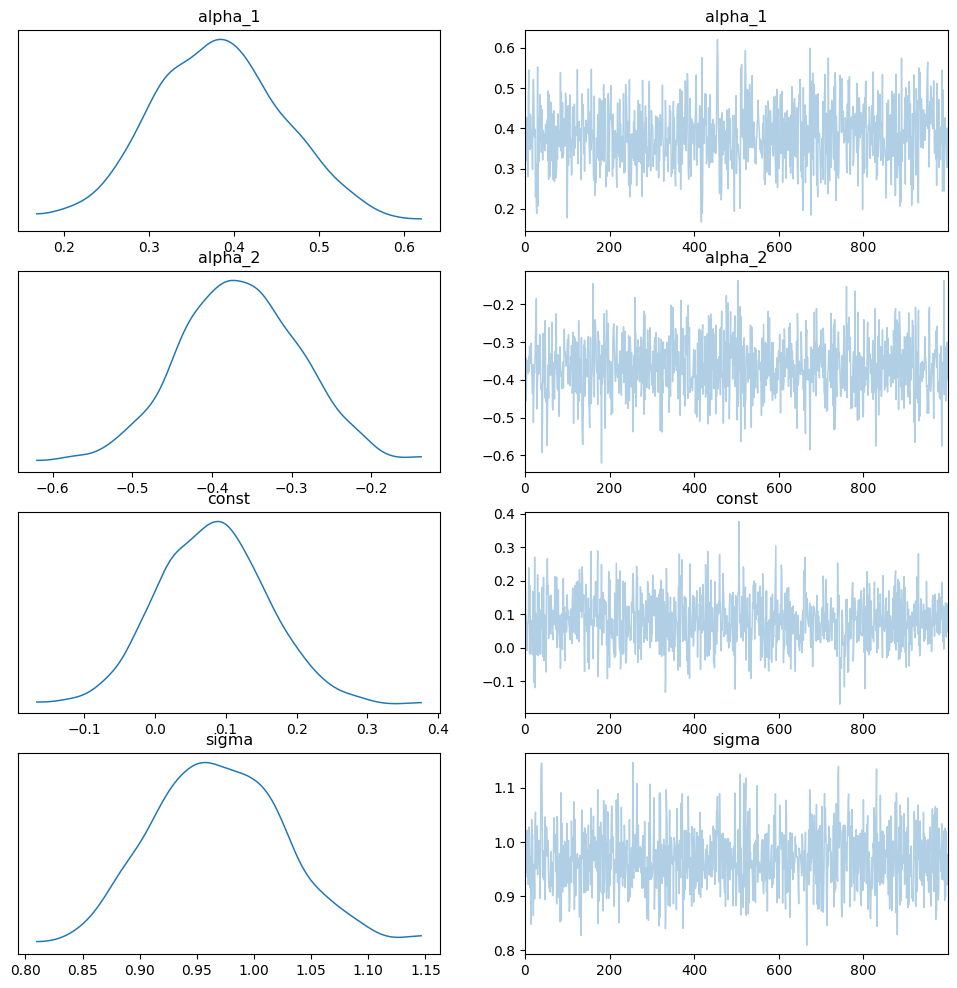

In [182]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(12,12));

### Posterior Predictive

Calling `Predictive` and adding in the `posterior_samples` parameter gives us a posterior predictive. But, because $y$ is observed this doesn't do anything. So we won't use it here.

## Local Level model

Let's begin with a super simple example - the local level model.

A local level model is *essentially* a gaussian random walk, or a regression model in where the intercept changes over time.

$$
\begin{aligned}
y_t &= \mu_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\mu_{t+1} &= \mu_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

This can also be represented as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma^2_\epsilon)\\
\mu_{t+1} &\sim \mathcal{N}(\mu_t, \sigma^2_\xi)\\
\sigma^2_\epsilon, \sigma^2_\xi &\sim \text{HalfCauchy}(1)
\end{aligned}
$$

In [217]:
def local_level(y):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # sigma_obs = 1
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    level_0 = y[0]

    def transition_fn(carry, t):
        level_t = carry
        # State Transition
        level_t = numpyro.sample(f"level", dist.Normal(level_t, sigma_level))
        # Observation equation
        y_t = numpyro.sample("y", dist.Normal(level_t, sigma_obs))  # observed
        
        return level_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, init=level_0, xs=jnp.arange(1, N)
        )

Here we use the `condition` handler so that we only `scan` over all the values of `y` except for the first one, because the first time step is used to set the initial values for this model.

## render model

It can help to render the model to see what's going on:

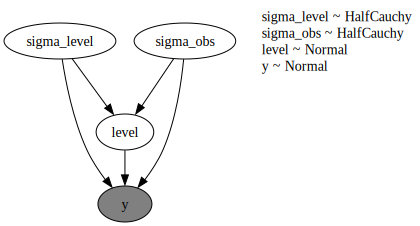

In [218]:
y = locations
numpyro.render_model(local_level, model_args=(y,), render_distributions=True)

In [219]:
## Prior Predictive
num_samples = 50
prior_predictive = Predictive(local_level, num_samples=num_samples)
prior_predictions = prior_predictive(rng_key, y)['level']

Plotting the prior predictions gets us nowhere because we conditioned on the observed values of `y`:

In [220]:
prior_predictions.shape

(50, 99)

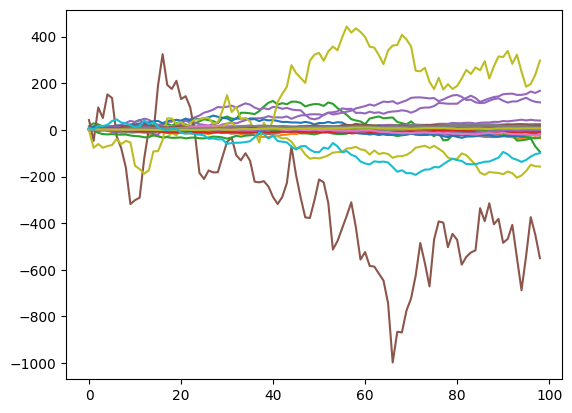

In [221]:
x = jnp.arange(0, prior_predictions.shape[1])
for i in range(num_samples):
    plt.plot(x, prior_predictions[i])

In [222]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, y)

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1132.11it/s, 63 steps of size 7.64e-02. acc. prob=0.97] 


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]      1.54      0.22      1.54      1.20      1.91   1731.20      1.00
     level[1]      1.67      0.25      1.72      1.26      2.06    108.52      1.00
     level[2]      0.12      0.23      0.12     -0.24      0.48   1719.00      1.00
     level[3]     -1.34      0.25     -1.38     -1.70     -0.94    226.92      1.00
     level[4]     -1.78      0.23     -1.79     -2.17     -1.41   1033.76      1.00
     level[5]     -1.80      0.23     -1.77     -2.21     -1.44    800.73      1.00
     level[6]     -2.20      0.23     -2.17     -2.58     -1.81    500.86      1.00
     level[7]     -3.38      0.22     -3.38     -3.73     -3.01   1169.07      1.00
     level[8]     -4.85      0.22     -4.88     -5.18     -4.46    286.39      1.00
     level[9]     -5.22      0.25     -5.26     -5.60     -4.80    343.46      1.00
    level[10]     -4.81      0.24     -4.85     -5.13     -4.37    140.34  

## Local Level Nile Model

In [196]:
import statsmodels.api as sm
import pandas as pd

# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

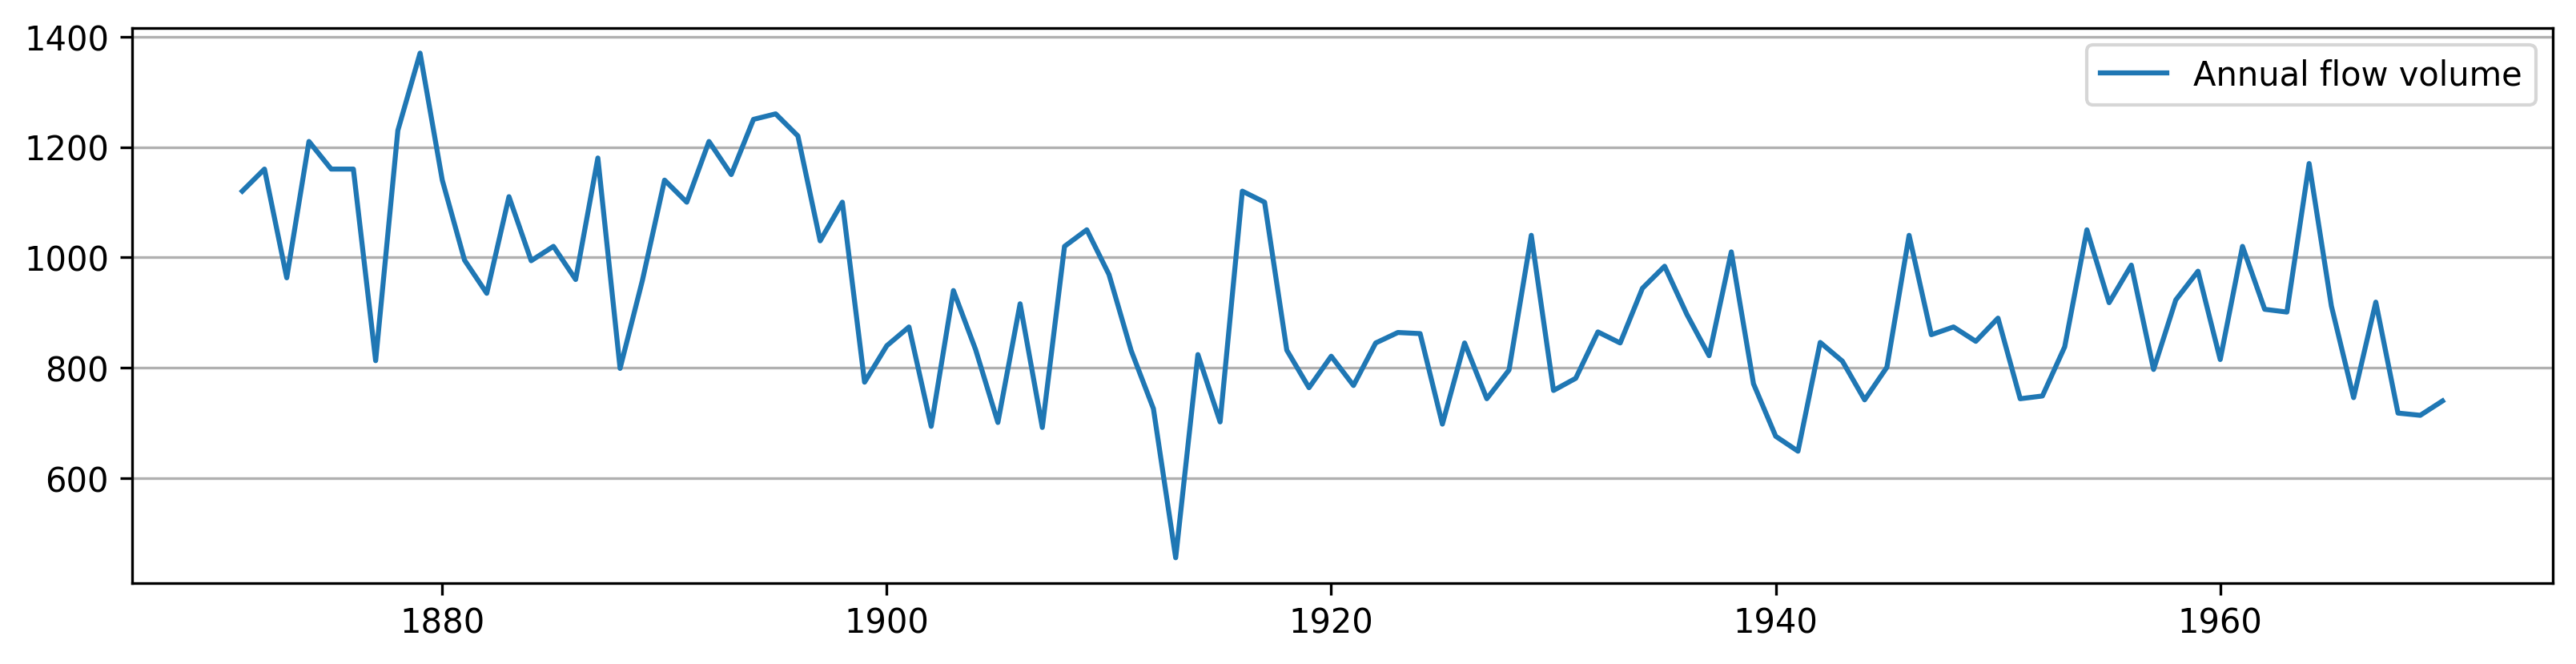

In [197]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

In [199]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1141.37it/s, 63 steps of size 1.27e-01. acc. prob=0.90]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]   1117.06     31.54   1116.54   1071.62   1170.19   1168.62      1.00
     level[1]   1110.36     38.38   1110.83   1042.88   1166.74   1029.80      1.00
     level[2]   1115.00     43.53   1112.32   1048.47   1189.31    912.31      1.00
     level[3]   1114.54     46.35   1112.23   1039.12   1189.69    794.95      1.00
     level[4]   1107.16     45.91   1106.89   1042.56   1191.39    903.93      1.00
     level[5]   1095.32     46.68   1096.07   1020.77   1169.32    808.19      1.00
     level[6]   1111.78     49.76   1109.31   1030.19   1189.24    529.55      1.00
     level[7]   1118.42     51.65   1116.10   1029.84   1193.22    237.43      1.00
     level[8]   1099.29     47.10   1097.72   1026.14   1178.33    447.41      1.00
     level[9]   1075.28     46.21   1077.70    998.83   1146.38    671.49      1.00
    level[10]   1060.78     45.27   1063.04    987.17   1132.79    517.87  

In [209]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Sigma Level: 35.97351


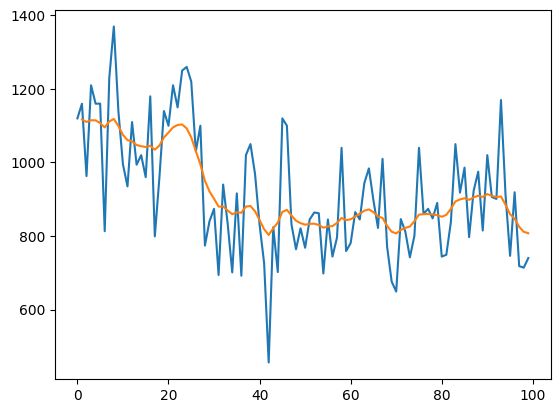

In [210]:
plt.plot(range(100), nile.values)
plt.plot(jnp.arange(1, 100), posterior_mean_level)

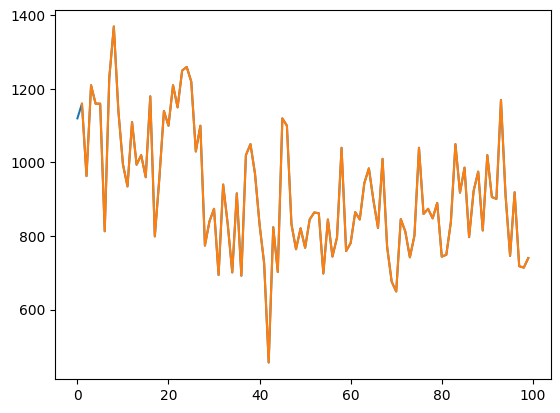

In [215]:
predictive = Predictive(local_level, samples)
preds = predictive(rng_key, y=jnp.array(nile.values))['y']
posterior_mean_y = jnp.mean(preds, axis=0)

plt.plot(range(100), nile.values)
plt.plot(jnp.arange(1, 100), posterior_mean_y)

## Simple Exponential Smoothing

Adapted from https://num.pyro.ai/en/stable/examples/holt_winters.html

SES is:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\ell_t, \sigma_t)\\
\ell_t &= \alpha y_t + (1- \alpha)\ell_{t-1}
\end{aligned}
$$

Unlike the previous functions, there is a new `future` argument so that we can do some forecasts.

In [ ]:
def ses(y, future=0):
    T = y.shape[0]
    alpha = numpyro.sample("alpha", dist.Beta(1, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level = carry
        level = jnp.where(
            t < T,
            alpha * (y[t]) + (1 - alpha) * (previous_level),
            previous_level,
        )
        mu = numpyro.deterministic('mu', previous_level)
        pred = numpyro.sample("pred", dist.Normal(mu, sigma))
        return level, pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(transition_fn, init=level_init, xs=jnp.arange(T + future))

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [ ]:
# Inference
kernel = NUTS(ses)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1540.67it/s, 7 steps of size 7.95e-01. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha      0.67      0.02      0.67      0.63      0.70    803.27      1.00
  level_init      0.69      1.10      0.74     -1.24      2.37   1110.63      1.00
       sigma     43.19      0.50     43.22     42.44     44.09   1026.32      1.00

Number of divergences: 0


In [ ]:
# Get posterior samples
samples = mcmc.get_samples()

In [ ]:
from numpyro.diagnostics import hpdi

predictive = Predictive(ses, samples, return_sites=["y_forecast", 'pred', 'mu'])
preds = predictive(rng_key, y=y, future=10)
mean_preds = preds['pred'].mean(axis=0)
hpdi_preds = hpdi(preds['pred'])

mean_fcst = preds['y_forecast'].mean(axis=0)
hpdi_fcst = hpdi(preds['y_forecast'])

Just like before we don't get past 1-step ahead predictions but we do get the final forecast:

In [ ]:
mean_mu = preds['mu'].mean(axis=0)
hpdi_mu = hpdi(preds['mu'])

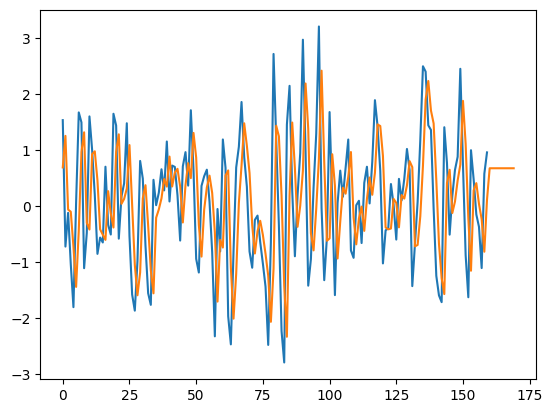

In [ ]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_mu)), mean_mu)

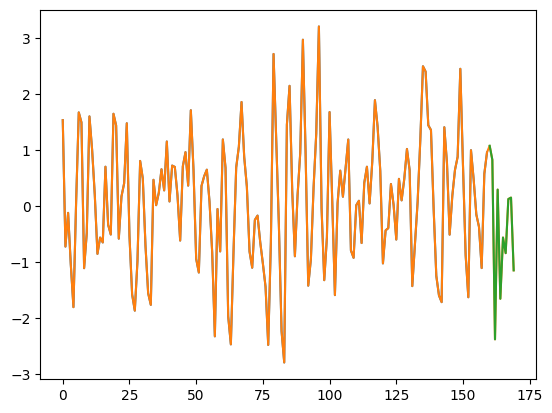

In [ ]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_preds)), mean_preds)
plt.plot(range(len(mean_preds))[-len(mean_fcst):], mean_fcst)

So I'll need to read a little more to figure out how to make this more worthwhile. So far this Bayesian model is useful to infer the hidden smoothing parameter $\alpha$ and noise $\sigma$ and to product a rudimentary forecast, but we'd need to add some extra bells and whistles so we can:

1. Evaluate the performance of this model using a 1-step ahead forecast on the past
2. Figure out how to do some of this stuff faster?
3. Take all the posterior possibilities of $\alpha$ and test how well that would have performed?

In [224]:
import numpy as np
res = np.zeros(len(y))
alpha = 0.67
for i in np.arange(1, len(y)-1):
    res[i] = (alpha * y[i] + (1-alpha) * res[i-1])

In [230]:
res = jnp.zeros(len(y))
alpha = 0.67
for i in np.arange(1, len(y)-1):
    res.at[i].set(alpha * y[i] + (1-alpha) * res[i-1])

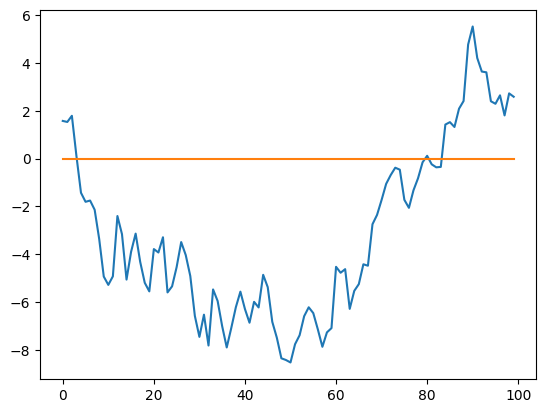

In [231]:
plt.plot(range(len(y)), y)
plt.plot(range(len(y)), res)

## Holt Winters


In [ ]:
def holt_winters(y, n_seasons, future=0):
    T = y.shape[0]
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))
    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry
        level = jnp.where(
            t < T,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )
        trend = jnp.where(
            t < T,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )
        new_season = jnp.where(
            t < T,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )
        step = jnp.where(t < T, 1, t - T + 1)
        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )
        return (level, trend, seasonality), pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(T + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

# Regression with Time Varying Coefficients

Similar to the local level, we can do a dynamic regression with time varying coefficients. A simple way to model time varying coefficients is to model the evolution as a random walk:

$$
\begin{aligned}
y_t &= x_t\beta_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\beta_{t+1} &= \beta_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

where $x_t$ is a $1 \times k$ vector of data and $\beta_t$ is a $k \times 1$ vector of coefficients at time $t$.

### Note: WIP (doesn't work)

In [ ]:
def dynamic_regression(y, X):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    # level_0 = y[0]
    beta_0 = numpyro.sample("beta_0", dist.Normal(0,1.0))

    def transition_fn(carry, t):
        beta_t = carry
        # State Transition
        beta_t = numpyro.sample(f"level", dist.Normal(beta_t, sigma_level))
        
        # Observation equation
        mu_t = X @ beta_t
        y_t = numpyro.sample("y", dist.Normal(mu_t, sigma_obs))
        
        return beta_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, init=beta_0, xs=jnp.arange(0, N)
        )